# Inverted pendulum test notebook
Derived from Tutorial 4

In [1]:
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from math import comb

import wecopttool as wot
import os

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

wot.set_loglevel('INFO', capytaine=False)
data_path = os.path.join('pioneer_data')


## 1. Model setup

In [2]:
grav = 9.80665 # m/s^2

### 1.1 Waves

In [3]:
fend = 1.875
nfreq_irreg = 150
f1_irreg = fend / nfreq_irreg

wavefreq = 0.325
# wavefreq = 0.25
# wavefreq = 0.4    #nothing

# f1_reg = wavefreq/2
# nfreq_reg = 12

f1_reg = wavefreq
nfreq_reg = 5

In [4]:
# regular
amplitude = 0.15

waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)


# irregular
Hs = 1.5
Tp = 5 
nrealizations = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1_irreg, nfreq_irreg, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations=nrealizations)

### 1.2 Basic properties

#### Geometry

In [5]:
in2m = 0.0254 # inch -> meter conversion factor
draft = 0.5 # meters
freeboard = 40. * in2m - draft
hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                             r2=110./2 * in2m, 
                             h1=22.679 * in2m,
                             h2=17.321 * in2m,
                             scale_factor=1,
                             freeboard=freeboard)
mesh = hull_geom.mesh(mesh_size_factor=0.5)

In [6]:
buoy_props = {
    'CG': 0.298, # m
    'MOI': 7484., # kg-m^2
    'Resonance frequency': 0.35, # Hz
}

#### Hydrodynamics and hydrostatics

In [7]:
pnr_fb = cpy.FloatingBody.from_meshio(mesh, name="Pioneer")
pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
pnr_fb.add_rotation_dof(name='Pitch')
pnr_fb.rotation_center = pnr_fb.center_of_mass
ndof = pnr_fb.nb_dofs

pnr_fb.inertia_matrix = xr.DataArray(data=np.asarray(([[buoy_props['MOI']]])),
                            dims=['influenced_dof', 'radiating_dof'],
                            coords={'influenced_dof': list(pnr_fb.dofs),
                                    'radiating_dof': list(pnr_fb.dofs)},
                            name="inertia_matrix")

In [8]:
rho = 1025. # kg/m^3

bem_data_string_reg = 'pioneer_reg_nfreq'+f'{nfreq_reg}'+'_wvfrq_'+f'{wavefreq}' +'.nc'
bem_data_fname_reg = os.path.join(data_path,bem_data_string_reg)
freq_reg = wot.frequency(f1_reg, nfreq_reg, False) # False -> no zero frequency
if os.path.isfile(bem_data_fname_reg):
    print("Found existing BEM file, loading")
    bem_data_reg = wot.read_netcdf(bem_data_fname_reg)
else:
    bem_data_reg = wot.run_bem(pnr_fb, freq_reg)
    wot.write_netcdf(bem_data_fname_reg, bem_data_reg)
omega_reg = bem_data_reg.omega.values

bem_data_string_irreg = 'pioneer_irreg_nfreq'+f'{nfreq_irreg}'+'.nc'
bem_data_fname_irreg = os.path.join(data_path,bem_data_string_irreg)
freq_irreg = wot.frequency(f1_irreg, nfreq_irreg, False) # False -> no zero frequency
if os.path.isfile(bem_data_fname_irreg):
    print("Found existing BEM file, loading")
    bem_data_irreg = wot.read_netcdf(bem_data_fname_irreg)
else:
    bem_data_irreg = wot.run_bem(pnr_fb, freq_irreg)
    wot.write_netcdf(bem_data_fname_irreg, bem_data_irreg)
omega_irreg = bem_data_irreg.omega.values

pnr_fb.keep_immersed_part()
k_buoy = pnr_fb.compute_hydrostatic_stiffness(rho=rho).values.squeeze()

Found existing BEM file, loading
Found existing BEM file, loading


In [9]:
pendulum_properties = {
    'coulomb_friction': 1.8, # N*m, coulomb friction from main bearings, in pendulum frame
    'viscous_friction': 1*1.7, # N*ms/rad
    # 'motor_gear_ratio': 0.118,
    'MOI': 7.605, # kgm^2, from CAD
    # 'mass': 10.0, # kg
    'mass': 244, # kg, via CAD
    'length': 0.5, # m
    'center_of_mass': 0.1248, #m, above pendulum shaft, via CAD
}
pendulum_properties['MOI_pointmass'] = pendulum_properties['mass']*pendulum_properties['center_of_mass']**2


spring_properties = {
    'stiffness': 305, # N*m/rad, Linearized for ±90° 
    'gear_ratio': 1,
    # 'Max torque': 750, # N-m
    # 'Max displacement': np.deg2rad(45.0), # rad
}


belt_properties = {
    'gear_ratio': 112/34,
    'power_rating': 3100, #W    
}

#gearbox properties, Maxon GPX70 UP: 6.6
gearbox_properties = {
    'gear_ratio': 6.6/1,
    'max_conti_torque_output': 15,     #Nm OUTPUT
    'peak_torque_output': 18,     #Nm OUTPUT
    'mass_inertia': 8.06e-6,    #kgm^2

}
#generator properties Maxon IDX70L (60V)
generator_propoerties = {
    'torque_constant': 0.186,   #Nm/A
    'winding_resistance': 0.0718,   #Ohm
    'winding_inductance': 0.0, 
    'rotor_inertia': 0.000153, #kgm^2,
    'max_conit_motor_current': 17.1,  #A     #max conti torque = 17.1*0.186 = 3.18Nm, on gearbox side 3.18*6.6 = 21Nm > than gear box limit
    'motor_gearing_friction': 0.6125 #Nm #coulomb friction, in the space of the gear box output
}

# PTO properties, goes from relative speed to generator speed
pto_properties = {
    'gear_ratio': belt_properties['gear_ratio']*gearbox_properties['gear_ratio'],
    'torque_constant': generator_propoerties['torque_constant'],
    'winding_resistance': generator_propoerties['winding_resistance'],
    'winding_inductance': generator_propoerties['winding_inductance'], 
    'drivetrain_inertia': generator_propoerties['rotor_inertia'] + gearbox_properties['mass_inertia'],
    'drivetrain_friction': 0.0, #1.7 / (belt_properties['gear_ratio']*gearbox_properties['gear_ratio'])**2,
    'drivetrain_stiffness': 0.0,
}

In [10]:
#TODO 
#constrains
# rms belt power
# rms gearbox torque
# peak gearbox torque
# rms generator torque (should be less than GB)
#add motor+gearing Coulomb friction to pendulum

In [11]:
# load in the empirical data
datafile = 'data/pioneer_empirical_data.nc'
empirical_data = xr.load_dataset(datafile)

omega_data = empirical_data.omega
exc_coeff_data = empirical_data.exc_coeff_data_real + 1j*empirical_data.exc_coeff_data_imag
Zi_data = empirical_data.Zi_data_real + 1j*empirical_data.Zi_data_imag
Zi_stiffness = empirical_data.Zi_stiffness

# here extrapolation for impedance and padding with zeros for the excitation
exc_coeff_intrp_reg = exc_coeff_data.interp(omega = omega_reg, method='linear', kwargs={"fill_value": 0})
Zi_intrp_reg = Zi_data.interp(omega = omega_reg, kwargs={"fill_value": "extrapolate"})

exc_coeff_intrp_irreg = exc_coeff_data.interp(omega = omega_irreg, method='linear', kwargs={"fill_value": 0})
Zi_intrp_irreg = Zi_data.interp(omega = omega_irreg, kwargs={"fill_value": "extrapolate"})

In [12]:
hd = wot.add_linear_friction(bem_data_irreg, friction = None) 
# we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

Zi_bem = wot.hydrodynamic_impedance(hd)

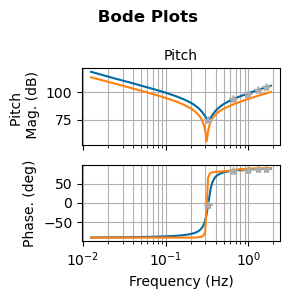

In [13]:

fig, axes = wot.utilities.plot_bode_impedance(Zi_intrp_irreg)
axes[0,0].semilogx(Zi_bem.omega.values/2/np.pi,
                20.0 * np.log10(np.abs(Zi_bem.squeeze())))
axes[1,0].semilogx(Zi_bem.omega.values/2/np.pi,
                np.rad2deg(np.unwrap(np.angle(Zi_bem.squeeze()))), label = "BEM")   

axes[0,0].semilogx(Zi_intrp_reg.omega.values/2/np.pi,
                20.0 * np.log10(np.abs(Zi_intrp_reg.squeeze())),
                marker = '*', linestyle = '' )
axes[1,0].semilogx(Zi_intrp_reg.omega.values/2/np.pi,
                np.rad2deg(np.unwrap(np.angle(Zi_intrp_reg.squeeze()))),
                label = "Empirical Regular wave",                             
                marker = '*', linestyle = '' )

##### Controller

In [31]:
def create_torque_function(control_type, nfreq_reg, nstate_pen):
    if control_type == 'unstructured':
        nstate_pto = 2 * nfreq_reg
        nstate_opt = nstate_pto + nstate_pen

        def torque_from_PTO(wec, x_wec, x_opt, waves=None, nsubsteps=1):
            f_fd = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')  # Take the first components for PTO torque
            time_matrix = wec.time_mat_nsubsteps(nsubsteps)
            torque = np.dot(time_matrix, f_fd)  # * pendulum_properties['motor_gear_ratio']
            return torque

    elif control_type == 'damping':
        nstate_pto = 1
        nstate_opt = nstate_pto + nstate_pen

        def torque_from_PTO(wec, x_wec, x_opt, waves=None, nsubsteps=1):
            pos_rel = x_rel(wec, x_wec, x_opt)
            vel_rel = np.dot(wec.derivative_mat, pos_rel)
            f_fd = x_opt[:nstate_pto] * vel_rel
            time_matrix = wec.time_mat_nsubsteps(nsubsteps)
            torque = np.dot(time_matrix, f_fd)  # * pendulum_properties['motor_gear_ratio']
            return torque
    elif control_type == 'PI':
        nstate_pto = 2
        nstate_opt = nstate_pto + nstate_pen
        def torque_PI(vel, pos, coeffs):
            return (coeffs[0] * vel +  
                coeffs[1] * pos) 
        def torque_from_PTO(wec, x_wec, x_opt, waves=None, nsubsteps=1):
            pos_rel = x_rel(wec, x_wec, x_opt)
            vel_rel = np.dot(wec.derivative_mat, pos_rel)
            f_fd = torque_PI(vel_rel, pos_rel, x_opt[:nstate_pto])
            time_matrix = wec.time_mat_nsubsteps(nsubsteps)
            torque = np.dot(time_matrix, f_fd) #* pendulum_properties['motor_gear_ratio']
            return torque
    elif control_type == 'PID':
        nstate_pto = 3
        nstate_opt = nstate_pto + nstate_pen
        def torque_PID(vel, pos, acc, coeffs):
            return (coeffs[0] * vel +  
                coeffs[1] * pos+
                coeffs[2] * acc) 
        def torque_from_PTO(wec, x_wec, x_opt, waves=None, nsubsteps=1):
            pos_rel = x_rel(wec, x_wec, x_opt)
            vel_rel = np.dot(wec.derivative_mat, pos_rel)
            acc_rel = np.dot(wec.derivative_mat, vel_rel)
            f_fd = torque_PID(vel_rel, pos_rel, acc_rel, x_opt[:nstate_pto])
            time_matrix = wec.time_mat_nsubsteps(nsubsteps)
            torque = np.dot(time_matrix, f_fd) #* pendulum_properties['motor_gear_ratio']
            return torque
    elif control_type == 'nonlinear_3rdO':
        nstate_pto = 7
        nstate_opt = nstate_pto + nstate_pen
        def torque_3rd_polynomial(vel, pos, coeffs):
            return (coeffs[0] +  #e1
                coeffs[1] * vel +  #e1
                coeffs[2] * pos + #e1
                coeffs[3] * vel**3 + #e1
                coeffs[4] * pos**3 + #e1
                coeffs[5] * vel**2 * pos + #e0
                coeffs[6] * vel * pos**2) #e1
        def torque_from_PTO(wec, x_wec, x_opt, waves=None, nsubsteps=1):
            pos_rel = x_rel(wec, x_wec, x_opt)
            vel_rel = np.dot(wec.derivative_mat, pos_rel)
            f_fd = torque_3rd_polynomial(vel_rel, pos_rel, x_opt[:nstate_pto])
            time_matrix = wec.time_mat_nsubsteps(nsubsteps)
            torque = np.dot(time_matrix, f_fd) #* pendulum_properties['motor_gear_ratio']
            return torque

    else:
        raise ValueError("Invalid control type. Choose 'unstructured', 'damping', or 'nonlinear_3rdO'.")

    return torque_from_PTO, nstate_pto, nstate_opt

In [32]:
nstate_pen = 2 * nfreq_reg  # pendulum positions
# nstate_opt = nstate_pto + nstate_pen

# control_type = 'damping'
# control_type = 'nonlinear_3rdO'
# control_type = 'unstructured'
# control_type = 'PI'
control_type = 'PID'

torque_from_PTO, nstate_pto, nstate_opt = create_torque_function(control_type, nfreq_reg, nstate_pen)

#### Manually defining PTO equations

##### Relative motion

In [33]:
def x_rel(wec, x_wec, x_opt):
    pos_wec = wec.vec_to_dofmat(x_wec)
    pos_pen = wec.vec_to_dofmat(x_opt[nstate_pto:])
    return pos_wec - pos_pen

def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, pos_rel)

def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    vel_rel = np.dot(wec.derivative_mat, pos_rel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_rel)

##### PTO Impedance

In [34]:
drivetrain_impedance = (1j*omega_reg*pto_properties['drivetrain_inertia'] +
                    pto_properties['drivetrain_friction'] +
                    1/(1j*omega_reg)*pto_properties['drivetrain_stiffness'])

winding_impedance = pto_properties['winding_resistance'] + 1j*omega_reg*pto_properties['winding_inductance']

pto_impedance_11 = -1* pto_properties['gear_ratio']**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * pto_properties['torque_constant'] * pto_properties['gear_ratio']
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega_reg.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega_reg.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                        [pto_impedance_21, pto_impedance_22]])


In [35]:
# pioneer_controller, nstate_pto = controller_pioneer('p')

pto = wot.pto.PTO(ndof, kinematics=[1], controller=None, impedance=pto_impedance, loss=None, names=None)


Damping_controller

Nonlinear structured controller

In [36]:
# nstate_pto = 10
# nstate_opt = nstate_pto + nstate_pen

# def torque_3rd_polynomial(vel, pos, coeffs):
#     return (coeffs[0] +  #e1
#         coeffs[1] * vel +  #e1
#         coeffs[2] * pos + #e1
#         coeffs[3] * vel**2 + 
#         coeffs[4] * pos**2 + 
#         coeffs[5] * vel**3 + #e1
#         coeffs[6] * pos**3 + #e1
#         coeffs[7] * vel * pos + 
#         coeffs[8] * vel**2 * pos + #e0
#         coeffs[9] * vel * pos**2) #e1



##### Power and Energy

In [37]:
def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    torque_td = torque_from_PTO(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * torque_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = torque_from_PTO(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(pto._transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf

### 1.4 Constraints

In [38]:
max_PTO_torque = gearbox_properties['peak_torque_output']*belt_properties['gear_ratio'] # N*m, gearbox is more limiting than generator
nsubsteps_constraints = 5

def constraint_max_generator_torque(wec, x_wec, x_opt, waves, nsubsteps=nsubsteps_constraints):
    torque = torque_from_PTO(wec, x_wec, x_opt, waves, nsubsteps)
    return max_PTO_torque - np.abs(torque.flatten())

### 1.5 Additional forces

In [39]:
# def torque_from_friction(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
#     rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps) * pendulum_properties['motor_gear_ratio']
#     fric =  -1*(
#         np.tanh(rel_vel)*pendulum_properties['coulomb_friction'] +
#         rel_vel*pendulum_properties['viscous_friction']
#     ) * pendulum_properties['motor_gear_ratio']
#     return fric


def nonlinear_torque_from_friction(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    #generator and gearbox have Clolumb friction, the we'll convert into the relative vel frame
    combined_Coulomg_friction = (pendulum_properties['coulomb_friction'] + 
                         generator_propoerties['motor_gearing_friction']*belt_properties['gear_ratio'])
    fric =  -1*(np.tanh(rel_vel)*combined_Coulomg_friction + rel_vel*pendulum_properties['viscous_friction']) 
    return fric


def linear_torque_from_friction(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps) 
    friction_torque =  -2* rel_vel*pendulum_properties['viscous_friction']  #increased viscous fric becuase no Coulomb
    return friction_torque


def torque_from_lin_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
        rel_pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) 
        spring_pos = spring_properties['gear_ratio'] * rel_pos
        linear_spring_torque = -1* spring_properties['stiffness'] * spring_pos
        linear_spring_torque_on_shaft = spring_properties['gear_ratio'] * linear_spring_torque
        return linear_spring_torque_on_shaft

def nonlinear_spring_torque(spring_pos):
    # 135 deg nonlinear spring
    spring_eq_pos_td = spring_pos - np.pi
    n = 12
    slope = 1/(2**(2*n))*comb(2*n,n)
    scale = 1/slope
    new_pos = 0
    for ind in range(n):
        k = ind+1
        coeffs = comb(2*n, n-k)/(k*(2**(2*n-1)))
        new_pos = new_pos - coeffs*np.sin(k*spring_eq_pos_td)
    return  -spring_properties['stiffness'] * scale * new_pos

def torque_from_nl_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    rel_pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) 
    spring_pos = spring_properties['gear_ratio'] * rel_pos
    spring_torque = nonlinear_spring_torque(spring_pos)
    spring_torque_on_shaft = spring_properties['gear_ratio']* spring_torque
    return spring_torque_on_shaft



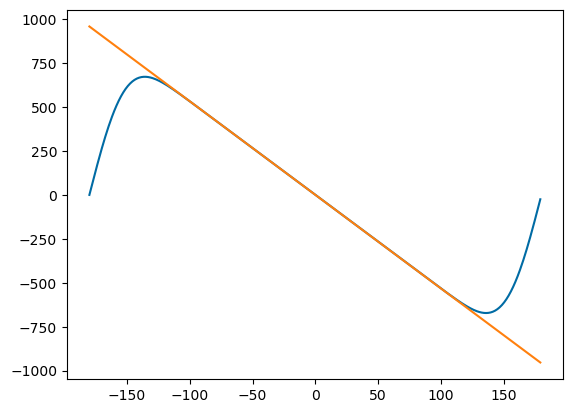

In [40]:
spring_angle_rad = np.arange(-np.pi, np.pi, np.pi/200)
spring_torque_test = nonlinear_spring_torque(spring_angle_rad)

plt.plot(spring_angle_rad*180/np.pi, spring_torque_test)
plt.plot(spring_angle_rad*180/np.pi, -spring_angle_rad*305)

### 1.6 Pendulum residual equation
Torque from inverted pendulum:

$$ \tau_{pen} = mgl \text{sin}(\theta_{pen}) $$

DG: In the actual dynamics torque get's added.... so need to flip the sign.. either here, on in residual.. gravity was negativ at first

In [41]:
def torque_from_pendulum(wec, x_wec, x_opt, waves=None, nsubsteps=1):
    pos_pen = wec.vec_to_dofmat(x_opt[nstate_pto:])
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_pen = np.dot(time_matrix, pos_pen)
    return -1*pendulum_properties['mass'] * grav * pendulum_properties['center_of_mass'] * np.sin(pos_pen)

In [42]:
def torque_from_linear_pendulum(wec, x_wec, x_opt, waves=None, nsubsteps=1):
    pos_pen = wec.vec_to_dofmat(x_opt[nstate_pto:])
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    pos_pen = np.dot(time_matrix, pos_pen)
    return -1*pendulum_properties['mass'] * grav * pendulum_properties['center_of_mass'] * pos_pen

In [43]:
def pendulum_inertia(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    pos_pen = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_pen = np.dot(wec.derivative2_mat, pos_pen)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_pen = np.dot(time_matrix, acc_pen)
    return pendulum_properties['MOI'] * acc_pen

In [44]:
def pendulum_residual_lin_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    resid = (
    pendulum_inertia(wec, x_wec, x_opt, waves, nsubsteps) +
    torque_from_linear_pendulum(wec, x_wec, x_opt, waves, nsubsteps) +
    torque_from_lin_spring(wec, x_wec, x_opt, waves, nsubsteps) +
    linear_torque_from_friction(wec, x_wec, x_opt, waves, nsubsteps) +
    torque_from_PTO(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return resid.flatten()

def pendulum_residual_nl_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    resid = (
    pendulum_inertia(wec, x_wec, x_opt, waves, nsubsteps) +
    torque_from_pendulum(wec, x_wec, x_opt, waves, nsubsteps) +
    torque_from_nl_spring(wec, x_wec, x_opt, waves, nsubsteps) +
    nonlinear_torque_from_friction(wec, x_wec, x_opt, waves, nsubsteps) +
    torque_from_PTO(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return resid.flatten()

In [45]:
f_add_lin_spring = {
    'Generator': torque_from_PTO,
    'Friction': linear_torque_from_friction,
    'Spring': torque_from_lin_spring,
    'Pendulum': torque_from_linear_pendulum,
}

f_add_nl_spring = {
    'Generator': torque_from_PTO,
    'Friction': nonlinear_torque_from_friction,
    'Spring': torque_from_nl_spring,
    'Pendulum': torque_from_pendulum,
}

f_add_nl_spring = {
    'Generator': torque_from_PTO,
    'Friction': nonlinear_torque_from_friction,
    'Spring': torque_from_nl_spring,
    'Pendulum': torque_from_pendulum,
}

constraints_lin_spring = [
    {'type': 'eq', 'fun': pendulum_residual_lin_spring}, # pendulum EoM
    {'type': 'ineq', 'fun': constraint_max_generator_torque},
]

constraints_nl_spring = [
    {'type': 'eq', 'fun': pendulum_residual_nl_spring}, # pendulum EoM
    {'type': 'ineq', 'fun': constraint_max_generator_torque},
]

### 1.7 WEC object

In [46]:
wec_lin = wot.WEC.from_impedance(freq_reg, Zi_intrp_reg,exc_coeff_intrp_reg,
                            Zi_stiffness,
                            f_add_lin_spring,
                            constraints_lin_spring)

wec_nl = wot.WEC.from_impedance(freq_reg, Zi_intrp_reg,exc_coeff_intrp_reg,
                            Zi_stiffness,
                            f_add_nl_spring,
                            constraints_nl_spring)

## 2. Regular wave results

### 2.1 Solve linear WEC

In [47]:
obj_fun = average_electrical_power

# def obj_fun(wec, x_wec, x_opt, waves, nsubsteps=1):
#     pos_pen= wec.vec_to_dofmat(x_opt[nstate_pto:])
#     average_power = average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
#     return average_power+ 10*np.sum(np.sqrt(pos_pen**2))

results = wec_lin.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    optim_options={'maxiter': 500},
    scale_x_wec=1e1,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1e-1 * np.ones(nstate_pen))),
    scale_obj=1e-0,
)
x_wec_0, x_opt_0 = wec_lin.decompose_state(results[0].x)


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.32e+02, 1.27e+03, 2.30e+16]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.21e+00, 4.67e-01, -6.70e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 4.42e-01, -2.86e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.18e+00, 8.38e-01, -2.73e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.16e+00, 1.06e+00, -2.62e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.16e+00, 8.41e-01, -4.34e+01]
INFO:wecopttool.core:Scaled [max(x_wec), max(

Optimization terminated successfully    (Exit mode 0)
            Current function value: -50.21838405539063
            Iterations: 14
            Function evaluations: 21
            Gradient evaluations: 14


### 2.2 Solve nonlinear WEC

In [48]:

results = wec_nl.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    optim_options={'maxiter': 500},
    x_wec_0=x_wec_0, # initialize with result from linear spring case
    x_opt_0=x_opt_0, # initialize with result from linear spring case
    scale_x_wec=1e1,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1e-1 * np.ones(nstate_pen))),
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

# # results = wec_nl.solve(
# #     waves_regular,
# #     obj_fun,
# #     nstate_opt,
# #     optim_options={'maxiter': 500},
# #     # x_wec_0=x_wec_0, # initialize with result from linear spring case
# #     # x_opt_0=x_opt_0, # initialize with result from linear spring case
# #     scale_x_wec=1e1,
# #     scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1e-1 * np.ones(nstate_pen))),
# #     scale_obj=1e-2,
# # )

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.18e+00, 8.34e-01, 2.01e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.19e+00, 8.81e-01, -2.20e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.19e+00, 1.32e+00, -3.30e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 1.46e+00, -2.47e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 1.55e+00, -2.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 1.54e+00, -2.56e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 1.52e+00, -2.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 1.41e+00, -2.60e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.20e+00, 1.30e+00, -2.62e-01]
INFO:wecopttool.core:Scaled [max

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.28793271787171776
            Iterations: 418
            Function evaluations: 1163
            Gradient evaluations: 418
Optimal average power: -28.79 W


### 2.2 Post-process and plot

In [49]:
nsubsteps = 5
wec_fdom, wec_tdom = wec_nl.post_process(wec_nl, results, waves_regular, nsubsteps=nsubsteps)
t = wec_tdom[0].time.values

# Manually post-process PTO and pendulum outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq_reg)
x_pen = x_opt[nstate_pto:]
pen_pos = np.dot(wec_nl.time_mat_nsubsteps(nsubsteps), x_pen)
dx_pen = np.dot(wec_nl.derivative_mat, x_pen)
pen_vel = np.dot(wec_nl.time_mat_nsubsteps(nsubsteps), dx_pen)  
pto_pos = rel_position(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_torque = torque_from_PTO(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_torque_fd = wec_nl.td_to_fd(pto_torque[::nsubsteps])
spring_torque = torque_from_nl_spring(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)

pen_inertia_torque = pendulum_inertia(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
spring_pos = pto_pos * spring_properties['gear_ratio']
pto_mech_power = mechanical_power(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pen_torque = torque_from_pendulum(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

Coulomb_friction_torque = nonlinear_torque_from_friction(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)

pen_residual = pendulum_residual_nl_spring(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)

wec_pos = wec_tdom[0]['pos'].squeeze()
wec_vel = wec_tdom[0]['vel'].squeeze()


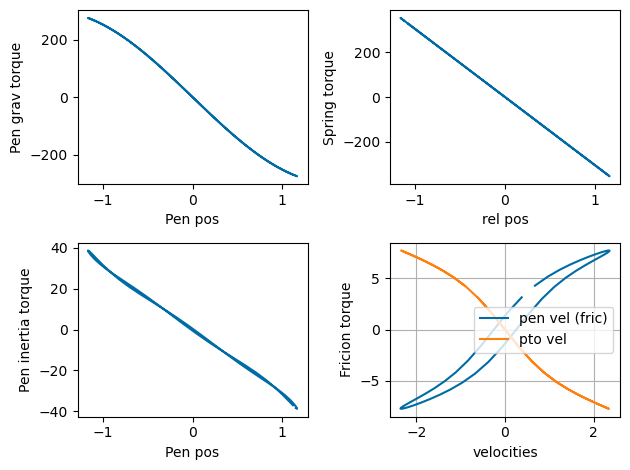

In [50]:
fig, axes = plt.subplots(2,2, tight_layout = True)
axes[0,0].plot(pen_pos, pen_torque)
axes[0,0].set_xlabel('Pen pos')
axes[0,0].set_ylabel('Pen grav torque')

axes[0,1].plot(pto_pos, spring_torque)
axes[0,1].set_xlabel('rel pos')
axes[0,1].set_ylabel('Spring torque')

axes[1,1].plot(pen_vel, Coulomb_friction_torque, label = 'pen vel (fric)')
axes[1,1].plot(pto_vel,Coulomb_friction_torque, label = 'pto vel')
# axes[1,1].plot(wec_vel,friction_torque, label = 'wec vel')
axes[1,1].set_ylabel('Fricion torque')
axes[1,1].set_xlabel('velocities')
axes[1,1].legend()


axes[1,0].plot(pen_pos, pen_inertia_torque)
axes[1,0].set_xlabel('Pen pos')
axes[1,0].set_ylabel('Pen inertia torque')

axes[1,1].grid(True)

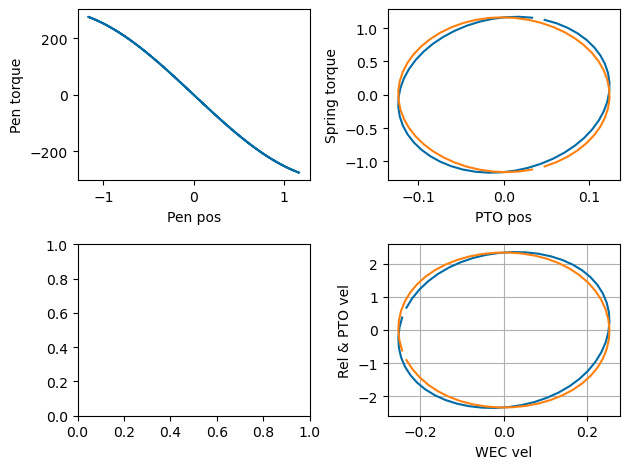

In [51]:
fig, axes = plt.subplots(2,2, tight_layout = True)
axes[0,0].plot(pen_pos, pen_torque)
axes[0,0].set_xlabel('Pen pos')
axes[0,0].set_ylabel('Pen torque')

axes[0,1].plot(wec_pos, pen_pos)
axes[0,1].plot(wec_pos, pto_pos)

axes[0,1].set_xlabel('PTO pos')
axes[0,1].set_ylabel('Spring torque')

axes[1,1].plot(wec_vel,pen_vel)
axes[1,1].plot(wec_vel,pto_vel)

axes[1,1].set_xlabel('WEC vel')
axes[1,1].set_ylabel('Rel & PTO vel')

axes[1,1].grid(True)

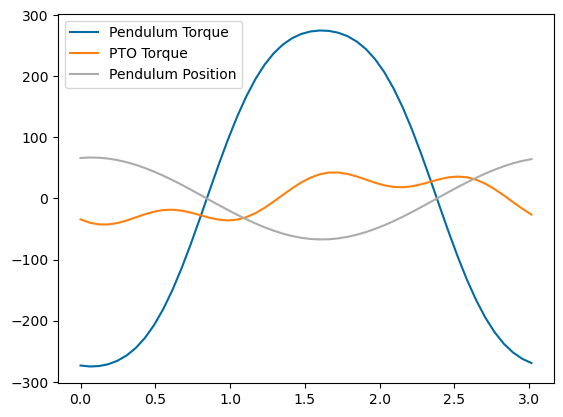

In [52]:
fig1, ax1 = plt.subplots()
ax1.plot(t, pen_torque, label='Pendulum Torque')
ax1.plot(t, pto_torque, label='PTO Torque')

ax1.plot(t, pen_pos*180/np.pi, label='Pendulum Position')

ax1.legend()

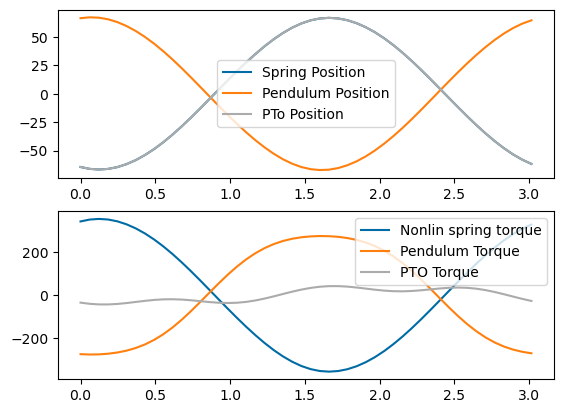

In [53]:
fig1, axes = plt.subplots(2,1)
axes[0].plot(t, spring_pos*180/np.pi, label='Spring Position')
axes[0].plot(t, pen_pos*180/np.pi, label='Pendulum Position')
axes[0].plot(t, pto_pos*180/np.pi, label='PTo Position')

axes[0].legend()


axes[1].plot(t, spring_torque, label='Nonlin spring torque')
axes[1].plot(t, pen_torque, label='Pendulum Torque')
axes[1].plot(t, pto_torque, label='PTO Torque')

# wec_tdom[0]['force'].sel(type = 'excitation').plot(ax = axes[1], label = 'excitation')

axes[1].legend()


In [54]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
fig, ax = plt.subplots()

# Set the limits of the plot
xlim = [-1.2, 1.2]
dx = xlim[1]-xlim[0]
ylim0 = -0.8
ylim = [ylim0, ylim0+dx]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Number of frames for the animation
frames = len(t)
pendulum_angles = pen_pos  # Sine wave for the circle
buoy_angles = wec_tdom[0]['pos'].squeeze()
pendulum_max_torque = (pendulum_properties['mass'] * grav * pendulum_properties['center_of_mass'] )
pendulum_torque_norm = pen_torque / pendulum_max_torque
spring_torque_norm = spring_torque / pendulum_max_torque# 614.7460754866761  #max value numericall from the acutal used function
spring_torque_rel = spring_torque / pendulum_max_torque
friction_torque_rel = Coulomb_friction_torque /pendulum_max_torque
pendulum_inerta_torque_norm = pen_inertia_torque / pendulum_max_torque



pto_torque_rel = pto_torque / pendulum_max_torque
pow_norm_factor = 200
pto_elec_power_norm = pto_elec_power / pow_norm_factor

# Rectangle and truncated cone parameters
buoy_width = 1.8
buoy_height = 0.6
cone_height = 0.6
cone_radius_top = buoy_width / 4  # Top radius matches half the rectangle width
cone_radius_bottom = buoy_width /2 # Bottom radius matches the rectangle width


delta_y = 0.2
len_pen = 0.5
def torque_to_arc(pen_torque_norm):
    return (0, 90 * pen_torque_norm) if pen_torque_norm >= 0 else (90 * pen_torque_norm, 0)

def animate(frame):
    plt.cla()  # Clear the current axes
    
    # Get the predefined angles for the current frame
    angle_pen = pendulum_angles[frame]
    angle_buoy = buoy_angles[frame]
    torque_pen = pendulum_torque_norm[frame].item()
    torque_spring = spring_torque_norm[frame].item()
    scale_spring_torqe = spring_torque_rel[frame].item()
    torque_friction = friction_torque_rel[frame].item()
    torque_pen_inertia = pendulum_inerta_torque_norm[frame].item()

    torque_pto = pto_torque_rel[frame].item()
    power_pto = pto_elec_power_norm[frame].item()

    # Calculate the x and y coordinates of the point
    x_pen = len_pen * np.sin(angle_pen)
    y_pen = len_pen * np.cos(angle_pen)
    
    # Plot the line from the origin to the red marker
    plt.plot([0, x_pen], [0, y_pen], 'r--')  # Dashed red line
    
    # Plot the point on the circle
    plt.plot(x_pen, y_pen, 'ro')  # 'ro' means red color, circle marker
    
    # Calculate the coordinates of the rectangular shape
    buoy_x = np.array([-buoy_width / 2, buoy_width / 2, buoy_width / 2, -buoy_width / 2, -buoy_width / 2])
    buoy_y = np.array([-buoy_height / 2, -buoy_height / 2, buoy_height / 2, buoy_height / 2, -buoy_height / 2]) + delta_y
    
    # Rotate the rectangle using the predefined angle
    rotation_matrix = np.array([[np.cos(angle_buoy), -np.sin(angle_buoy)],
                                 [np.sin(angle_buoy), np.cos(angle_buoy)]])
    buoy_rotated = rotation_matrix @ np.vstack((buoy_x, buoy_y))
    
    # Plot the rectangle
    plt.plot(buoy_rotated[0, :], buoy_rotated[1, :], color='green')  # Green rectangle
    
    # Create the truncated cone
    cone_x = np.linspace(-cone_radius_bottom, cone_radius_bottom, 2)
    cone_y_top = np.full_like(cone_x, -buoy_height / 2) +delta_y # Top of the cone
    cone_y_bottom = cone_y_top - cone_height +delta_y # Bottom of the cone
    
    # Calculate the coordinates for the truncated cone
    cone_top = np.vstack((cone_x, cone_y_top))
    cone_bottom = np.vstack((cone_x * (cone_radius_top / cone_radius_bottom), cone_y_bottom))
    
    # Create the sides of the truncated cone
    left_side = np.array([[cone_x[0], cone_y_top[0]], [cone_x[0] * (cone_radius_top / cone_radius_bottom), cone_y_bottom[0]]])
    right_side = np.array([[cone_x[-1], cone_y_top[-1]], [cone_x[-1] * (cone_radius_top / cone_radius_bottom), cone_y_bottom[-1]]])
    
    # Rotate the truncated cone
    cone_rotated_top = rotation_matrix @ cone_top
    cone_rotated_bottom = rotation_matrix @ cone_bottom
    left_side_rotated = rotation_matrix @ left_side.T
    right_side_rotated = rotation_matrix @ right_side.T
    
    # Plot the truncated cone
    plt.plot(cone_rotated_top[0, :], cone_rotated_top[1, :], color='green')  # Top of the cone
    plt.plot(cone_rotated_bottom[0, :], cone_rotated_bottom[1, :], color='green')  # Bottom of the cone
    plt.plot(left_side_rotated[0, :], left_side_rotated[1, :], color='green')  # Left side of the cone
    plt.plot(right_side_rotated[0, :], right_side_rotated[1, :], color='green')  # Right side of the cone

    plt.plot([1.1, 1.1],[-1, -1-power_pto],  color='green', linewidth=10, alpha = 0.5)
    plt.text(1.2, ylim0+0.2, f'{-1*power_pto*pow_norm_factor:.1f}W')
    th1pen, th2pen = torque_to_arc(torque_pen)
    arcpen = patches.Arc((0, 0), 0.5, 0.5, angle=90, theta1=th1pen, theta2=th2pen, color='red', linewidth=2, alpha = 0.5, label = 'pen. gravit.')
    ax.add_patch(arcpen)
    # arc = patches.Arc((0, 0), 0.5, 0.5, angle=90, theta1=0, theta2=90, color='red', linewidth=1.2)

    th1_spring, th2_spring = torque_to_arc(torque_spring)
    arc_spring = patches.Arc((0, 0), 0.6, 0.6, angle=90, theta1=th1_spring, theta2=th2_spring, color='blue', linewidth=2, alpha = 0.5, label ='Spring')
    ax.add_patch(arc_spring)

    th1_pto, th2_pto = torque_to_arc(torque_pto)
    arc_pto = patches.Arc((0, 0), 0.4, 0.4, angle=90, theta1=th1_pto, theta2=th2_pto, color='orange', linewidth=2, alpha = 0.5, label = 'PTO')
    ax.add_patch(arc_pto)

    th1_inertia, th2_inertia = torque_to_arc(torque_pen_inertia)
    arc_inertia = patches.Arc((0, 0), 0.45, 0.45, angle=90, theta1=th1_inertia, theta2=th2_inertia, color='yellow', linewidth=2, alpha = 0.5, label = 'pen. inertia')
    ax.add_patch(arc_inertia)

    th1_fric, th2_fric = torque_to_arc(torque_friction)
    arc_fric = patches.Arc((0, 0), 0.3, 0.3, angle=90, theta1=th1_fric, theta2=th2_fric, color='black', linewidth=2, alpha = 0.5, label = 'friction')
    ax.add_patch(arc_fric)

    # Set the limits and aspect ratio
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')  # Keep the aspect ratio square
    ax.grid(True)  # Turn on the grid
    ax.legend(loc = 'upper left')

# Create the animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=frames)
ani

In [55]:

# ani.save('pioneer_reg_'+f'{wavefreq}'.replace('.','p')+'damping_only.gif', writer='imagemagick', fps=1/(t[1]-t[0]))

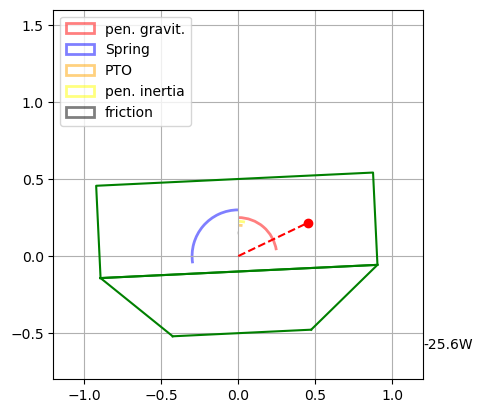

In [56]:
%matplotlib inline
plt.rcParams["animation.html"] = "none"
plt.show()


What causes that very irregular pendulum torque?!
Is the torque limit to restricting?
Do we forget something in the pendulum model? It does full rotations...
basically, you fully wind up the spring and then unwind it...

In [57]:
wec_tdom[0]['force'].sel(type = 'excitation').plot(ax = axes[1], label = 'excitation')


672.0246203245648

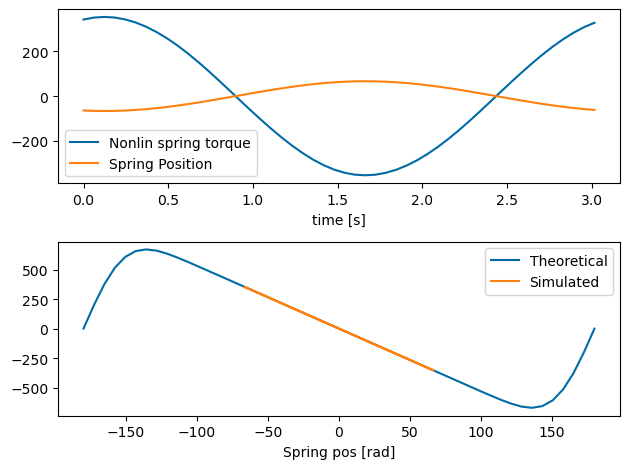

In [58]:
fig1, axes = plt.subplots(2,1, tight_layout = True)
axes[0].plot(t, spring_torque, label='Nonlin spring torque')
axes[0].plot(t, spring_pos*180/np.pi, label='Spring Position')
axes[0].legend()
axes[0].set_xlabel('time [s]')

lin_pos = np.pi*np.linspace(-1,1,len(t))
axes[1].plot(lin_pos*180/np.pi, nonlinear_spring_torque(lin_pos), label='Theoretical')
axes[1].plot(spring_pos*180/np.pi, spring_torque, label='Simulated')
axes[1].set_xlabel('Spring pos [rad]')
# axes[2].plot(t, lin_pos*180/np.pi, label='lin pos')

axes[1].legend()
np.max(nonlinear_spring_torque(lin_pos))

Text(0.5, 0, 'Time [s]')

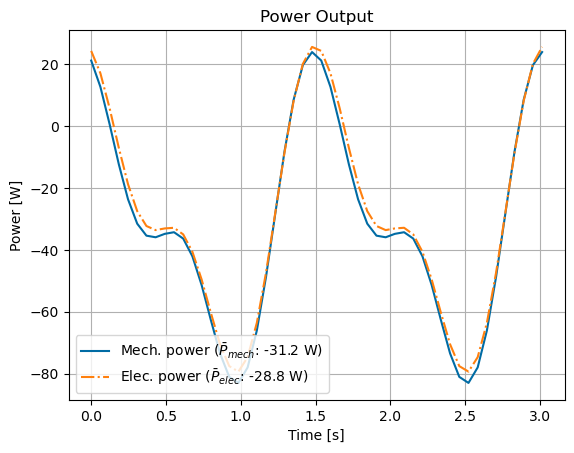

In [59]:
fig2, ax2 = plt.subplots()
ax2.plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax2.plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax2.set_title('Power Output')
ax2.set_ylabel('Power [W]')
ax2.grid(True)
ax2.legend()
ax2.set_xlabel('Time [s]')

Text(0.5, 0, 'PTO_vel')

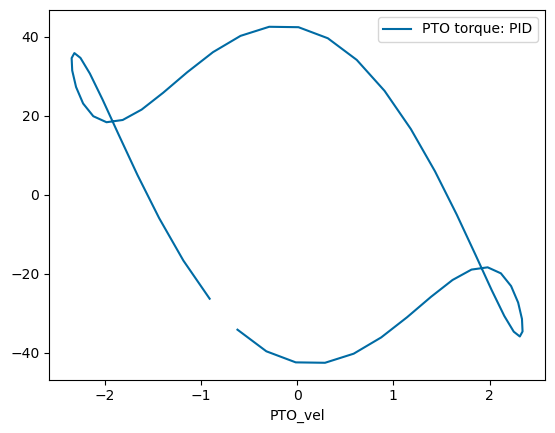

In [60]:
fig2, ax2 = plt.subplots()
ax2.plot(pto_vel, pto_torque, label='PTO torque: '+control_type )


# ax2.plot(pto_vel, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')

ax2.legend()
ax2.set_xlabel('PTO_vel')

Text(0.5, 0.5, 'PTO_pos')

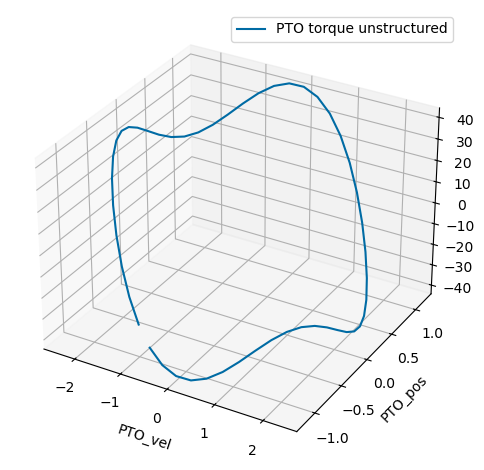

In [61]:
fig = plt.figure(tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
ax.plot(pto_vel, pto_pos, pto_torque, label='PTO torque unstructured' )
ax.legend()
ax.set_xlabel('PTO_vel')
ax.set_ylabel('PTO_pos')

In [62]:
# Create a design matrix for a second-order polynomial
# The polynomial will be of the form: a + b * pto_vel + c * pto_pos + d * pto_vel^2 + e * pto_pos^2 + f * pto_vel * pto_pos
X_1st = np.column_stack((np.ones(pto_vel.shape[0]), pto_vel, pto_pos, pto_vel * pto_pos))

# Fit the polynomial using least squares
coefficients_1st, residuals, rank, singular_values = np.linalg.lstsq(X_1st, pto_torque, rcond=None)

# Print the coefficients
print("Fitted coefficients 1st O:", coefficients_1st)

# Create a function to predict torque based on the fitted polynomial
def torque_1st_polynomial(vel, pos):
    return (coefficients_1st[0] + 
            coefficients_1st[1] * vel + 
            coefficients_1st[2] * pos + 
            coefficients_1st[3] * vel * pos)

Fitted coefficients 1st O: [[ 3.43671214e-14]
 [-1.11631681e+01]
 [ 2.25655728e+01]
 [-2.05119318e-14]]


In [63]:
# Create a design matrix for a second-order polynomial
# The polynomial will be of the form: a + b * pto_vel + c * pto_pos + d * pto_vel^2 + e * pto_pos^2 + f * pto_vel * pto_pos
X_2nd = np.column_stack((np.ones(pto_vel.shape[0]), pto_vel, pto_pos, pto_vel**2, pto_pos**2, pto_vel * pto_pos))

# Fit the polynomial using least squares
coefficients_2nd, residuals, rank, singular_values = np.linalg.lstsq(X_2nd, pto_torque, rcond=None)

# Print the coefficients
print("Fitted coefficients 2nd O:", coefficients_2nd)

# Create a function to predict torque based on the fitted polynomial
def torque_2nd_polynomial(vel, pos):
    return (coefficients_2nd[0] + 
            coefficients_2nd[1] * vel + 
            coefficients_2nd[2] * pos + 
            coefficients_2nd[3] * vel**2 + 
            coefficients_2nd[4] * pos**2 + 
            coefficients_2nd[5] * vel * pos)



Fitted coefficients 2nd O: [[ 9.89450547e-12]
 [-1.11631681e+01]
 [ 2.25655728e+01]
 [-1.78373727e-12]
 [-7.25429121e-12]
 [ 1.90715891e-14]]


In [64]:
# Create a design matrix for a third-order polynomial
# The polynomial will be of the form:
# a + b * pto_vel + c * pto_pos + d * pto_vel^2 + e * pto_pos^2 + f * pto_vel^3 + g * pto_pos^3 + h * pto_vel * pto_pos + i * pto_vel^2 * pto_pos + j * pto_vel * pto_pos^2
X_3rd = np.column_stack((
    np.ones(pto_vel.shape[0]), 
    pto_vel, 
    pto_pos, 
    pto_vel**2, 
    pto_pos**2, 
    pto_vel**3, 
    pto_pos**3, 
    pto_vel * pto_pos, 
    pto_vel**2 * pto_pos, 
    pto_vel * pto_pos**2
))

# Fit the polynomial using least squares
coefficients_3rd, residuals, rank, singular_values = np.linalg.lstsq(X_3rd, pto_torque, rcond=None)

# Print the coefficients
print("Fitted coefficients 3rd order:", coefficients_3rd)

# Create a function to predict torque based on the fitted polynomial
def torque_3rd_polynomial(vel, pos):
    return (coefficients_3rd[0] +  #e1
        coefficients_3rd[1] * vel +  #e1
        coefficients_3rd[2] * pos + #e1
        coefficients_3rd[3] * vel**2 + 
        coefficients_3rd[4] * pos**2 + 
        coefficients_3rd[5] * vel**3 + #e1
        coefficients_3rd[6] * pos**3 + #e1
        coefficients_3rd[7] * vel * pos + 
        coefficients_3rd[8] * vel**2 * pos + #e0
        coefficients_3rd[9] * vel * pos**2) #e1

Fitted coefficients 3rd order: [[ 5.02028188e-13]
 [-1.04405449e+02]
 [-1.84758982e+02]
 [-9.46600153e-14]
 [-3.01982734e-13]
 [ 1.63946475e+01]
 [ 1.63728456e+02]
 [ 4.67722372e-15]
 [ 2.91553004e+01]
 [ 7.36964908e+01]]


Text(0.5, 0, 'PTO_vel')

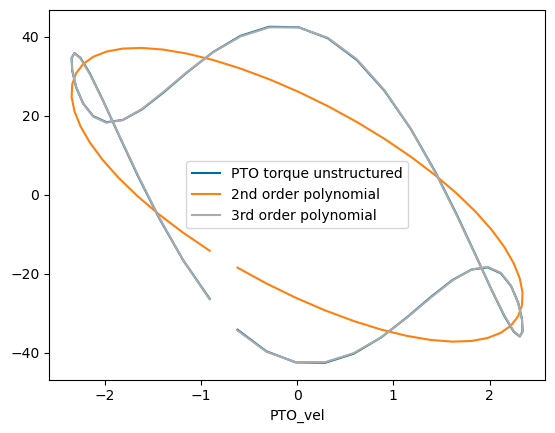

In [65]:
fig2, ax2 = plt.subplots()
ax2.plot(pto_vel, pto_torque, label='PTO torque unstructured' )

ax2.plot(pto_vel, torque_2nd_polynomial(pto_vel, pto_pos), label='2nd order polynomial' )
ax2.plot(pto_vel, torque_3rd_polynomial(pto_vel, pto_pos), label='3rd order polynomial' )

# ax2.plot(pto_vel, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')

ax2.legend()
ax2.set_xlabel('PTO_vel')

Text(0.5, 0, 'torque')

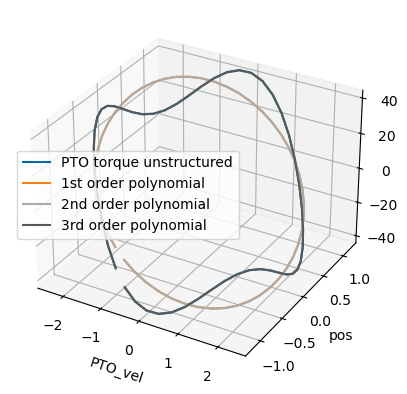

In [66]:

fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot(pto_vel, pto_pos, pto_torque, label='PTO torque unstructured' )

ax2.plot(pto_vel,pto_pos, torque_1st_polynomial(pto_vel, pto_pos), label='1st order polynomial' )
ax2.plot(pto_vel,pto_pos, torque_2nd_polynomial(pto_vel, pto_pos), label='2nd order polynomial' )
ax2.plot(pto_vel,pto_pos, torque_3rd_polynomial(pto_vel, pto_pos), label='3rd order polynomial' )

# ax2.plot(pto_vel, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')

ax2.legend()
ax2.set_xlabel('PTO_vel')
ax2.set_ylabel('pos')
ax2.set_zlabel('torque')
# ax2.view_init(elev=0, azim=45, roll=-0)

Text(0.5, 0, 'PTO_pos')

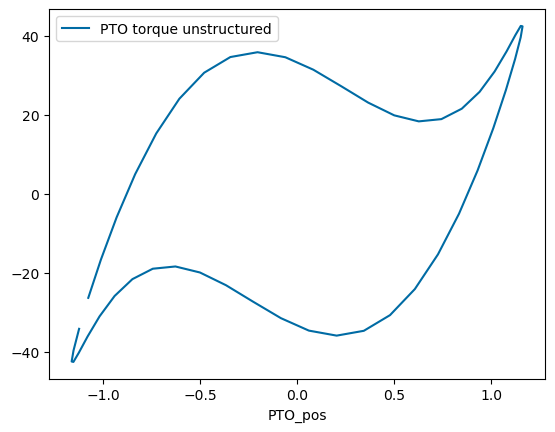

In [67]:
fig2, ax2 = plt.subplots()
ax2.plot(pto_pos, pto_torque, label='PTO torque unstructured' )
# ax2.plot(pto_vel, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')

ax2.legend()
ax2.set_xlabel('PTO_pos')

## 3. Irregular wave results


### 3.1 WEC objects


In [68]:
# wec_lin_irreg = wot.WEC.from_impedance(freq_irreg, Zi_intrp_irreg,exc_coeff_intrp_irreg,
#                             Zi_stiffness,
#                             f_add_lin_spring,
#                             constraints_lin_spring)

# wec_nl_irreg = wot.WEC.from_impedance(freq_irreg, Zi_intrp_irreg,exc_coeff_intrp_irreg,
#                             Zi_stiffness,
#                             f_add_nl_spring,
#                             constraints_nl_spring)

In [69]:
#TODO
#need to re-initialize the force etc. with the right components

In [70]:
# nstate_pto = 2 * nfreq_irreg # PTO forces
# nstate_pen = 2 * nfreq_irreg  # pendulum positions
# nstate_opt = nstate_pto + nstate_pen

In [71]:
# nstate_pto


### 3.1 Solve

In [72]:
# obj_fun = average_electrical_power
# results = wec_lin_irreg.solve(
#     waves_irregular,
#     obj_fun,
#     nstate_opt,
#     optim_options={'maxiter': 500},
#     scale_x_wec=1e1,
#     scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1e-1 * np.ones(nstate_pen))),
#     scale_obj=1e-0,
# )
# x_wec_0, x_opt_0 = wec_lin_irreg.decompose_state(results[0].x)

# results = wec_nl_irreg.solve(
#     waves_irregular,
#     obj_fun,
#     nstate_opt,
#     optim_options={'maxiter': 500},
#     x_wec_0=x_wec_0, # initialize with result from linear spring case
#     x_opt_0=x_opt_0, # initialize with result from linear spring case
#     scale_x_wec=1e1,
#     scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1e-1 * np.ones(nstate_pen))),
#     scale_obj=1e-2,
# )
# print(f'Optimal average power: {results[0].fun:.2f} W')

In [73]:
# nstate_pto